<center> <h1><bold>
<hr style="border-width:2px;border-color:#1664c8">
Exploration des fichiers <b>"small_vocab_en"</b> et <b>"small_vocab_fr"</b><br>
et 1ere tentative de traduction mot à mot,<br>
en mode non supervisé, puis supervisé
<hr style="border-width:2px;border-color:#1664c8">
</center> </h1></bold>

> **Importation des bibliothèques :**

In [23]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


> **Définition d'une fonction pour lire les fichiers :**

In [24]:
def load_data(path):

# Nombre maximum de lignes à renvoyer
    max_lines = 140000
    
    input_file = os.path.join(path)
    with open(input_file, "r",  encoding="utf-8") as f:
        data = f.read()
        
    # On convertit les majuscules en minulcule
    # data = data.lower()
    
    data = data.split('\n')
    return data[:min(len(data),max_lines)]

> **Définition d'une fonction de nettoyage des phrases non traduites, i.e. identiques dans les 2 langues**

In [25]:
def clean_untranslated_sentence(data1, data2):
    i=0
    while i<len(data1):
        if data1[i]==data2[i]:
            data1.pop(i)
            data2.pop(i)
        else: i+=1
    return data1,data2

> **Définition d'une fonction de splitage des phrases en mots :**

In [26]:
def split_sentence (sentence):

    REPLACEMENTS = [
                    (",", " "),
                    (";", " "),
                    (":", " "),
                    ("?", " "),
                    ('"', " "),
                    ("-", " "),
                    ("it's", "it is"),
                    ("isn't","is not"),
                    ("'", " ")
    ]
     
    # On enlève l ponctuation et on la remplace par des ' '
    for old, new in REPLACEMENTS:
        sentence = sentence.replace(old, new)

    # On crée un tableau de mots, sentence_split
    sentence_split = sentence.split()

    return sentence_split
    

> **Préprocessing du texte pour pouvoir l'analyser**
>> **(a)** Elimination de la ponctuation
>>
>> **(b)** Elimination des phase non traduites
>>
>> **(c)** Splitage du texte en mots
>>
>> **(d)** Définition du corpus de mots utilisé
>>
>> **(e)** Comptage dans chaque phrase du nombre de mots uniques qui se trouvent dans le corpus

In [27]:
###
### Définition de la fonction preprocess_txt
###

def preprocess_txt (data):
    
    corpus = []
    data_split = []
     
    # Création d'un tableau de mot (sentence_split) et d'un corpus de mots (corpus)
    for sentence in data:
        
        # Pour chaque phrase, on crée un tableau de mots, sentence_split
        sentence_split = split_sentence(sentence)

        # Pour chaque mot de la phrase on vérifie s'il appartient au corpus de mots déjà trouvés.
        # Si ce n'est pas le cas, on le rajoute à corpus
        for t in sentence_split:
            if t not in corpus:
                corpus.append(t)
        data_split.append(sentence_split)

    # Affichage des 5 premiers txt_split
    print('Texte "splited":')
    for i in range(5):
        print("    ",data_split[i])
    print("")


    # Affichage du corpus de mots
    nb_phrases = len(data)
    nb_mots = len(corpus)
    print("Nombre de phrases: ",nb_phrases)
    print("Nombre de mots uniques: ",nb_mots)
    print("Mots uniques:")
    print(corpus[:500])
    
    # Création d'un DataFrame txt_n_unique_val :
    #      colonnes = mots
    #      lignes = phases
    #      valeur de la cellule = nombre d'occurence du mot dans la phrase 
    txt_n_unique_val = pd.DataFrame(columns=corpus,dtype='int',index=range(nb_phrases))
    txt_n_unique_val.fillna(0, inplace=True)
    for i,sentence_split in enumerate(data_split):
        for word in sentence_split:
            txt_n_unique_val.iloc[i,corpus.index(word)] += 1
    print("\nNombre d'apparitions de chaque mot dans la phrase:")
    display(txt_n_unique_val.iloc[:,:30].head(10))
    print("========\n")

    return corpus, data_split, txt_n_unique_val

In [28]:
#Chargement des textes dans les 2 langues (max lignes = max_lines)
txt_en = load_data('data/small_vocab_en')
txt_fr = load_data('data/small_vocab_fr')

# Elimination des phrases non traduites
txt_en, txt_fr = clean_untranslated_sentence(txt_en, txt_fr)

# Affichage des 20 premieres lignes des textes dans les 2 langues
for i in range(20):
    print("EN: ",txt_en[i])
    print("FR: ",txt_fr[i],"\n")
print("========\n")

# Lancement du préprocessing du texte qui va spliter nettoyer les phrases et les spliter en mots 
print("Préprocessing de small_vocab_en :\n")
corpus_en, txt_split_en, df_count_word_en = preprocess_txt (txt_en)
print("Préprocessing de small_vocab_fr :\n")
corpus_fr, txt_split_fr, df_count_word_fr = preprocess_txt (txt_fr)

EN:  new jersey is sometimes quiet during autumn , and it is snowy in april .
FR:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril . 

EN:  the united states is usually chilly during july , and it is usually freezing in november .
FR:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre . 

EN:  california is usually quiet during march , and it is usually hot in june .
FR:  california est généralement calme en mars , et il est généralement chaud en juin . 

EN:  the united states is sometimes mild during june , and it is cold in september .
FR:  les états-unis est parfois légère en juin , et il fait froid en septembre . 

EN:  your least liked fruit is the grape , but my least liked is the apple .
FR:  votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme . 

EN:  his favorite fruit is the orange , but my favorite is the grape .
FR:  son fruit préféré est l'orange , mais mon préféré est le raisin . 

EN

,new,jersey,is,sometimes,quiet,during,autumn,and,it,snowy,...,california,march,hot,june,mild,cold,september,your,least,liked
0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
9,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Préprocessing de small_vocab_fr :

Texte "splited":
     ['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne', 'et', 'il', 'est', 'neigeux', 'en', 'avril']
     ['les', 'états', 'unis', 'est', 'généralement', 'froid', 'en', 'juillet', 'et', 'il', 'gèle', 'habituellement', 'en', 'novembre']
     ['california', 'est', 'généralement', 'calme', 'en', 'mars', 'et', 'il', 'est', 'généralement', 'chaud', 'en', 'juin']
     ['les', 'états', 'unis', 'est', 'parfois', 'légère', 'en', 'juin', 'et', 'il', 'fait', 'froid', 'en', 'septembre']
     ['votre', 'moins', 'aimé', 'fruit', 'est', 'le', 'raisin', 'mais', 'mon', 'moins', 'aimé', 'est', 'la', 'pomme']

Nombre de phrases:  137860
Nombre de mots uniques:  344
Mots uniques:
['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne', 'et', 'il', 'neigeux', 'en', 'avril', 'les', 'états', 'unis', 'généralement', 'froid', 'juillet', 'gèle', 'habituellement', 'novembre', 'california', 'mars', 'chaud', 'juin', 'légère'

,new,jersey,est,parfois,calme,pendant,l',automne,et,il,...,habituellement,novembre,california,mars,chaud,juin,légère,fait,septembre,votre
0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


> **Calcul du nombre d'occurences des mots dans chaque langue**

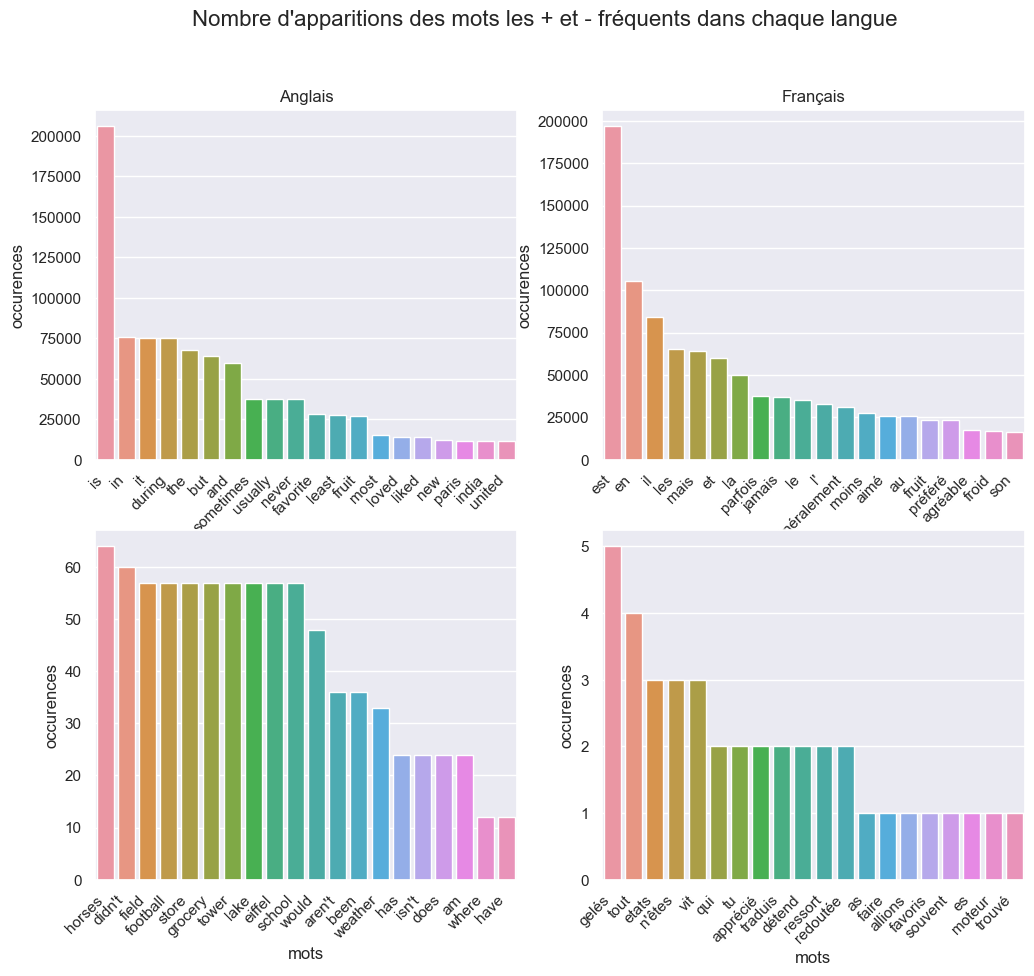

In [29]:

nb_occurences_en = pd.DataFrame(df_count_word_en.sum().sort_values(axis=0,ascending=False))
nb_occurences_en.columns = ['occurences']
nb_occurences_en.index.name = 'mot'
#print("Nombre d'occurences des mots en anglais:")
#display(nb_occurences_en)
nb_occurences_en['mots'] = nb_occurences_en.index


nb_occurences_fr = pd.DataFrame(df_count_word_fr.sum().sort_values(axis=0,ascending=False))
nb_occurences_fr.columns = ['occurences']
nb_occurences_fr.index.name = 'mot'
#print("\nNombre d'occurences des mots en français:")
#display(nb_occurences_fr)
nb_occurences_fr['mots'] = nb_occurences_fr.index

sns.set()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Nombre d'apparitions des mots les + et - fréquents dans chaque langue", fontsize=16)
axes[0,0].set_title('Anglais')
axes[0,1].set_title('Français')

chart1 = sns.barplot(ax=axes[0,0],x='mots',y='occurences',data=nb_occurences_en.iloc[:20]);
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')

chart2 = sns.barplot(ax=axes[0,1],x='mots',y='occurences',data=nb_occurences_fr.iloc[:20]);
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')

chart3 = sns.barplot(ax=axes[1,0],x='mots',y='occurences',data=nb_occurences_en.iloc[-20:]);
chart3.set_xticklabels(chart3.get_xticklabels(), rotation=45, horizontalalignment='right')

chart4 = sns.barplot(ax=axes[1,1],x='mots',y='occurences',data=nb_occurences_fr.iloc[-20:]);
chart4.set_xticklabels(chart4.get_xticklabels(), rotation=45, horizontalalignment='right');

> **Distribution de certains mots dans une phrase**

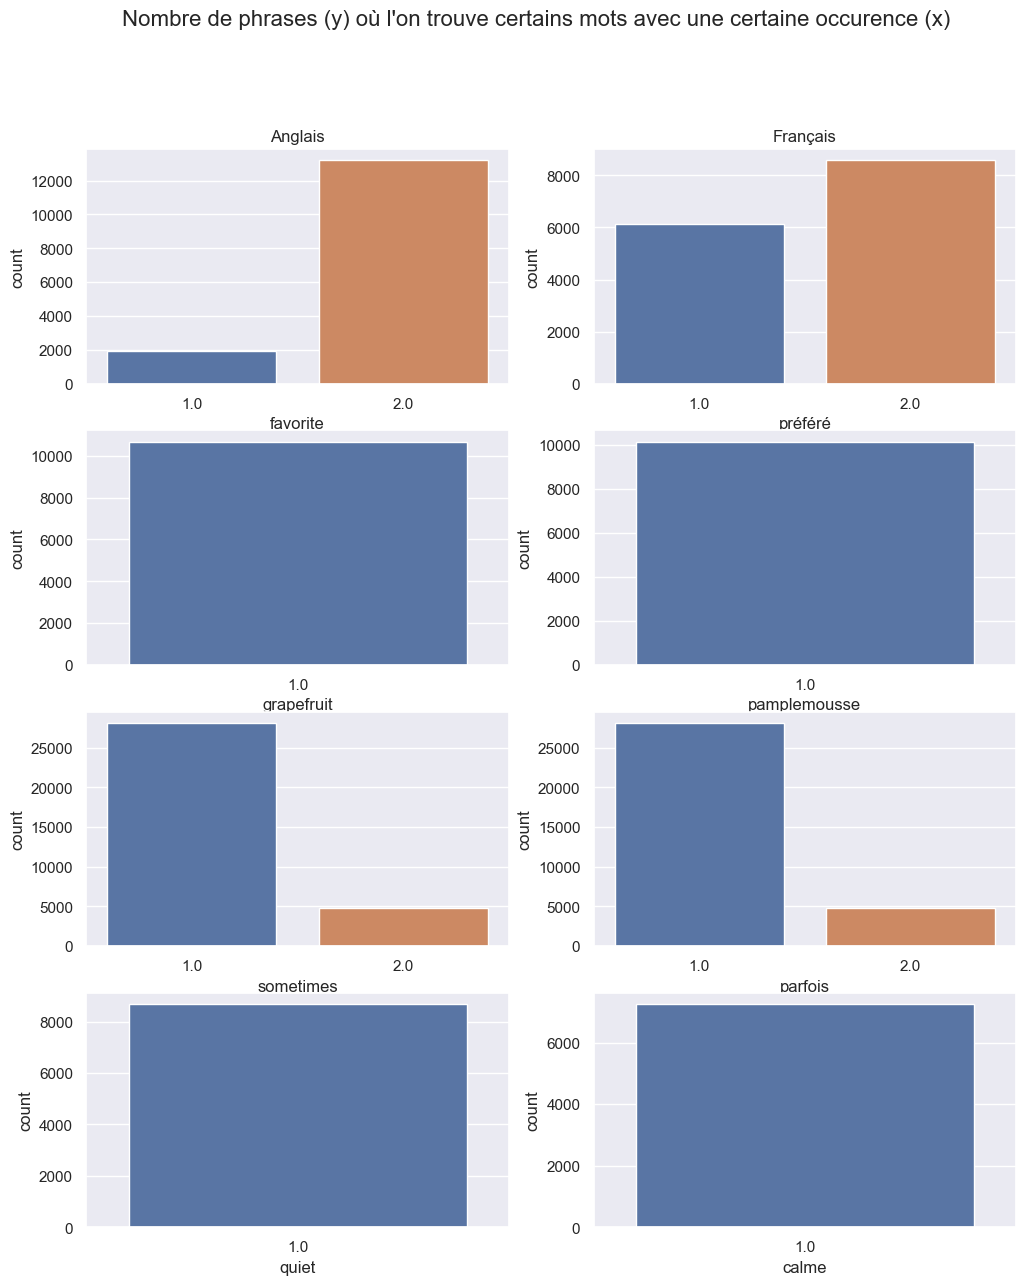

In [30]:
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
fig.suptitle("Nombre de phrases (y) où l'on trouve certains mots avec une certaine occurence (x)", fontsize=16)

axes[0,0].set_title('Anglais')
axes[0,1].set_title('Français')
sns.countplot(ax=axes[0,0],x=df_count_word_en['favorite'].loc[df_count_word_en['favorite']!=0]);
sns.countplot(ax=axes[1,0],x=df_count_word_en['grapefruit'].loc[df_count_word_en['grapefruit']!=0]);
sns.countplot(ax=axes[2,0],x=df_count_word_en['sometimes'].loc[df_count_word_en['sometimes']!=0]);
sns.countplot(ax=axes[3,0],x=df_count_word_en['quiet'].loc[df_count_word_en['quiet']!=0]);
sns.countplot(ax=axes[0,1],x=df_count_word_fr['préféré'].loc[df_count_word_fr['préféré']!=0]);
sns.countplot(ax=axes[1,1],x=df_count_word_fr['pamplemousse'].loc[df_count_word_fr['pamplemousse']!=0]);
sns.countplot(ax=axes[2,1],x=df_count_word_fr['parfois'].loc[df_count_word_fr['parfois']!=0]);
sns.countplot(ax=axes[3,1],x=df_count_word_fr['calme'].loc[df_count_word_fr['calme']!=0]);

In [31]:
nb_mots_en = len(corpus_en)
nb_mots_fr = len(corpus_fr)

# On modifie df_count_word en indiquant la présence d'un mot par 1 (au lieu du nombre d'occurences)
df_count_word_en = df_count_word_en[df_count_word_en==0].fillna(1)
df_count_word_fr = df_count_word_fr[df_count_word_fr==0].fillna(1)

# On triche un peu parce que new et jersey sont toujours dans la même phrase et donc dans la même classe
df_count_word_en['new']=df_count_word_en['new']*2
df_count_word_fr['new']=df_count_word_fr['new']*2


> **Création des dictionnaire Anglais -> Français et Français -> Anglais**<br>

> Pour evaluer l'efficacité, chargement des dictionnaires de reference (corrigés manuellement)

In [32]:
dict_FR_EN_ref = pd.read_csv('data/dict_fr_en.csv',header=0,index_col=0, encoding ="utf-8", sep=';').T
dict_EN_FR_ref = pd.read_csv('data/dict_en_fr.csv',header=0,index_col=0, encoding ="utf-8", sep=';').T
# display(dict_FR_EN_ref)
# display(dict_EN_FR_ref)

> Définition d'une fonction de **précision** du dictionnaire

In [33]:
def accuracy(dict_ref,dict):
    correct_words = 0
    
    for t in dict.columns:
        if t in dict_ref.columns:
            if str(dict[t]) == str(dict_ref[t]): 
                correct_words +=1
    print(correct_words," mots corrects / ",min(dict.shape[1],dict_ref.shape[1]))
    return correct_words/min(dict.shape[1],dict_ref.shape[1])

>> Création des dictionnaires à l'aide de la méthode non supervisée **KMeans**

In [34]:
# Création des dictionnaire Anglais -> Français

# Algorithme de K-means
init_centroids = df_count_word_fr.T
kmeans = KMeans(n_clusters = nb_mots_fr, n_init=1, max_iter=1, init=init_centroids, verbose=0)
# kmeans = KMedoids(n_clusters = nb_mots_fr, max_iter=10)

kmeans.fit(df_count_word_fr.T)

# Centroids and labels
centroids= kmeans.cluster_centers_
labels = kmeans.labels_

# Création et affichage du dictionnaire
dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[kmeans.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
dict_EN_FR.index.name='Anglais'
dict_EN_FR = dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_EN_FR_ref,dict_EN_FR)*100, 2)}%")
display(dict_EN_FR)


Dictionnaire Anglais -> Français:
181  mots corrects /  199
Précision du dictionnaire = 90.95%


Anglais,new,jersey,is,sometimes,quiet,during,autumn,and,it,snowy,...,lake,bears,school,birds,want,isn't,lions,am,mice,have
Francais,new,jersey,est,parfois,calme,en,automne,et,en,enneigée,...,lac,redoutée,l'école,oiseaux,veulent,allions,lions,vais,préférées,tu


In [35]:
# Création des dictionnaire Français -> Anglais

# Algorithme de K-means
init_centroids = df_count_word_en.T
kmeans = KMeans(n_clusters = nb_mots_en, n_init=1, max_iter=1, init=init_centroids, verbose=0)
#kmeans = KMedoids(n_clusters = nb_mots_en, max_iter=10)

kmeans.fit(df_count_word_en.T)

# Centroids and labels
centroids= kmeans.cluster_centers_
labels = kmeans.labels_

# Création et affichage du dictionnaire
dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[kmeans.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
dict_FR_EN.index.name='Francais'
dict_FR_EN = dict_FR_EN.T

print("Dictionnaire Français -> Anglais:")
#print(f"Précision du dictionnaire = {round(accuracy(dict_FR_EN_ref,dict_FR_EN)*100, 2)}%")
display(dict_FR_EN)

Dictionnaire Français -> Anglais:


Francais,new,jersey,est,parfois,calme,pendant,l',automne,et,il,...,tu,qui,faire,traduis,favoris,souvent,es,apprécié,moteur,tout
Anglais,new,jersey,is,sometimes,quiet,animal,india,autumn,and,it,...,states,states,states,states,states,states,states,states,states,states


>> Création des dictionnaires à l'aide de la méthode supervisée **KNN**

In [36]:
# Création des dictionnaire Anglais -> Français

#Définition de la metrique (pour les 2 dictionnaires
knn_metric = 'minkowski'   # minkowski, cosine, chebyshev, manhattan, euclidean

# Algorithme de KNN
X_train = df_count_word_fr.T
y_train = range(nb_mots_fr)

# Création du classifieur et construction du modèle sur les données d'entraînement
knn = KNeighborsClassifier(n_neighbors=1, metric=knn_metric)
knn.fit(X_train, y_train)

# Création et affichage du dictionnaire
knn_dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[knn.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
knn_dict_EN_FR.index.name='Anglais'
knn_dict_EN_FR = knn_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_EN_FR_ref,knn_dict_EN_FR)*100, 2)}%")
display(knn_dict_EN_FR)

Dictionnaire Anglais -> Français:
182  mots corrects /  199
Précision du dictionnaire = 91.46%


Anglais,new,jersey,is,sometimes,quiet,during,autumn,and,it,snowy,...,lake,bears,school,birds,want,isn't,lions,am,mice,have
Francais,new,jersey,est,parfois,calme,en,automne,et,en,enneigée,...,lac,redoutée,l'école,oiseaux,veulent,allions,lions,vais,préférées,tu


In [37]:
# Création des dictionnaire Français -> Anglais

#Définition de la metrique (pour les 2 dictionnaires
knn_metric = 'cosine'   # minkowski, cosine, chebyshev, manhattan, euclidean

# Algorithme de KNN
X_train = df_count_word_en.T
y_train = range(nb_mots_en)

# Création du classifieur et construction du modèle sur les données d'entraînement
knn = KNeighborsClassifier(n_neighbors=1, metric=knn_metric)
knn.fit(X_train, y_train)

# Création et affichage du dictionnaire
knn_dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[knn.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
knn_dict_FR_EN.index.name='Francais'
knn_dict_FR_EN = knn_dict_FR_EN.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_FR_EN_ref,knn_dict_FR_EN)*100, 2)}%")
display(knn_dict_FR_EN)

Dictionnaire Anglais -> Français:
258  mots corrects /  344
Précision du dictionnaire = 75.0%


Francais,new,jersey,est,parfois,calme,pendant,l',automne,et,il,...,tu,qui,faire,traduis,favoris,souvent,es,apprécié,moteur,tout
Anglais,jersey,jersey,is,sometimes,quiet,winter,india,autumn,and,it,...,have,rusty,would,think,lions,busy,have,apple,red,does


>> Création des dictionnaires à l'aide de la méthode supervisée **Random Forest**

In [38]:
# Création des dictionnaire Anglais -> Français

# Algorithme de Random Forest
X_train = df_count_word_fr.T
y_train = range(nb_mots_fr)

# Création du classifieur et construction du modèle sur les données d'entraînement
rf = RandomForestClassifier(n_jobs=-1, random_state=321)
rf.fit(X_train, y_train)

# Création et affichage du dictionnaire
rf_dict_EN_FR = pd.DataFrame(data=df_count_word_fr.columns[rf.predict(df_count_word_en.T)],index=df_count_word_en.T.index,columns=['Francais'])
rf_dict_EN_FR.index.name='Anglais'
rf_dict_EN_FR = rf_dict_EN_FR.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_EN_FR_ref,rf_dict_EN_FR)*100, 2)}%")
display(rf_dict_EN_FR)

Dictionnaire Anglais -> Français:
169  mots corrects /  199
Précision du dictionnaire = 84.92%


Anglais,new,jersey,is,sometimes,quiet,during,autumn,and,it,snowy,...,lake,bears,school,birds,want,isn't,lions,am,mice,have
Francais,new,jersey,est,parfois,calme,en,automne,et,en,neige,...,lac,ours,l'école,oiseaux,veulent,souvent,lions,vais,préférées,tu


In [39]:
# Création des dictionnaire Français -> Anglais

# Algorithme de Random Forest
X_train = df_count_word_en.T
y_train = range(nb_mots_en)

# Création du classifieur et construction du modèle sur les données d'entraînement
rf = RandomForestClassifier(n_jobs=-1, random_state=321)
rf.fit(X_train, y_train)

# Création et affichage du dictionnaire
rf_dict_FR_EN = pd.DataFrame(data=df_count_word_en.columns[rf.predict(df_count_word_fr.T)],index=df_count_word_fr.T.index,columns=['Anglais'])
rf_dict_FR_EN.index.name='Francais'
rf_dict_FR_EN = rf_dict_FR_EN.T

print("Dictionnaire Anglais -> Français:")
print(f"Précision du dictionnaire = {round(accuracy(dict_FR_EN_ref,rf_dict_FR_EN)*100, 2)}%")
display(rf_dict_FR_EN)

Dictionnaire Anglais -> Français:
187  mots corrects /  344
Précision du dictionnaire = 54.36%


Francais,new,jersey,est,parfois,calme,pendant,l',automne,et,il,...,tu,qui,faire,traduis,favoris,souvent,es,apprécié,moteur,tout
Anglais,new,jersey,is,sometimes,quiet,winter,india,autumn,and,it,...,have,have,have,have,have,have,have,have,have,have


> **Illustration d'anomalies**<br>
> Exemple: "the" traduit par "fruit" au lieu de "le" ou "la"

In [40]:
word_en = 'the'
word_fr1 = 'le'
word_fr2 = 'la'
word_fr_pred = dict_EN_FR[word_en][0]
print("Nombre de fois que l'on trouve le mot '",word_en,"' dans le texte anglais :",df_count_word_en[word_en].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr_pred,"' dans le texte français :",df_count_word_fr[word_fr_pred].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr1,"' dans le texte français :",df_count_word_fr[word_fr1].sum())
print("Nombre de fois que l'on trouve le mot '",word_fr2,"' dans le texte français :",df_count_word_fr[word_fr2].sum())

Nombre de fois que l'on trouve le mot ' the ' dans le texte anglais : 41221.0
Nombre de fois que l'on trouve le mot ' fruit ' dans le texte français : 23626.0
Nombre de fois que l'on trouve le mot ' le ' dans le texte français : 28877.0
Nombre de fois que l'on trouve le mot ' la ' dans le texte français : 39038.0


> **Exemples de traduction de phrase anglaise en utilisant les dictionnaire Anglais -> Français**

In [41]:
sentence1 = "paris is never freezing during november , but it is wonderful in october"
sentence2 = "the banana is their favorite fruit , but the grapefruit is your favorite" 
sentence3 = "that cat was my most loved animal"

print("\nTraduction à l'aide du dictionnaires de reference:")
display(dict_EN_FR_ref[split_sentence(sentence1)])
display(dict_EN_FR_ref[split_sentence(sentence2)])
display(dict_EN_FR_ref[split_sentence(sentence3)])
print("\n")

print("Traduction à l'aide du dictionnaires KMeans calculés:")
display(dict_EN_FR[split_sentence(sentence1)])
display(dict_EN_FR[split_sentence(sentence2)])
display(dict_EN_FR[split_sentence(sentence3)])
print("\n")

print("Traduction à l'aide du dictionnaires KNN calculés:")
display(knn_dict_EN_FR[split_sentence(sentence1)])
display(knn_dict_EN_FR[split_sentence(sentence2)])
display(knn_dict_EN_FR[split_sentence(sentence3)])
print("\n")

print("Traduction à l'aide du dictionnaires RF calculés:")
display(rf_dict_EN_FR[split_sentence(sentence1)])
display(rf_dict_EN_FR[split_sentence(sentence2)])
display(rf_dict_EN_FR[split_sentence(sentence3)])


Traduction à l'aide du dictionnaires de reference:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,il,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,le,banane,est,leur,préféré,fruit,mais,le,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,cher,animal




Traduction à l'aide du dictionnaires KMeans calculés:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,en,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,fruit,banane,est,leur,préféré,fruit,mais,fruit,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,plus,animal




Traduction à l'aide du dictionnaires KNN calculés:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,en,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,fruit,banane,est,leur,préféré,fruit,mais,fruit,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,plus,animal




Traduction à l'aide du dictionnaires RF calculés:


Anglais,paris,is,never,freezing,during,november,but,it,is,wonderful,in,october
Francais,paris,est,jamais,gel,en,novembre,mais,en,est,merveilleux,en,octobre


Anglais,the,banana,is,their,favorite,fruit,but,the,grapefruit,is,your,favorite
Francais,unis,banane,est,leur,préféré,fruit,mais,unis,pamplemousse,est,votre,préféré


Anglais,that,cat,was,my,most,loved,animal
Francais,cette,chat,était,mon,plus,plus,animal


> **Exemples de traduction de phrase anglaise en utilisant les dictionnaire Français -> Anglais**

In [42]:
sentence1 = "paris est jamais le gel en novembre , mais il est merveilleux en octobre ."
sentence2 = "la banane est leur fruit préféré , mais le pamplemousse est votre favori ." 
sentence3 = "ce chat était mon animal le plus aimé"

print("\nTraduction à l'aide du dictionnaire de reference:")
display(dict_FR_EN_ref[split_sentence(sentence1)])
display(dict_FR_EN_ref[split_sentence(sentence2)])
display(dict_FR_EN_ref[split_sentence(sentence3)])
print("\n")

print("Traduction à l'aide du dictionnaire Kmeans calculés:")
display(dict_FR_EN[split_sentence(sentence1)])
display(dict_FR_EN[split_sentence(sentence2)])
display(dict_FR_EN[split_sentence(sentence3)])
print("\n")

print("Traduction à l'aide du dictionnaire KNN calculés:")
display(knn_dict_FR_EN[split_sentence(sentence1)])
display(knn_dict_FR_EN[split_sentence(sentence2)])
display(knn_dict_FR_EN[split_sentence(sentence3)])
print("\n")

print("Traduction à l'aide du dictionnaire RF calculés:")
display(rf_dict_FR_EN[split_sentence(sentence1)])
display(rf_dict_FR_EN[split_sentence(sentence2)])
display(rf_dict_FR_EN[split_sentence(sentence3)])


Traduction à l'aide du dictionnaire de reference:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,the,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,the,banana,is,their,fruit,favorite,but,the,grapefruit,is,your,favorite


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,this,cat,was,my,animal,the,most,loved




Traduction à l'aide du dictionnaire Kmeans calculés:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,field,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,fruit,banana,is,their,fruit,favorite,but,field,field,is,your,states


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,this,cat,was,my,store,field,most,loved




Traduction à l'aide du dictionnaire KNN calculés:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,fruit,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,fruit,banana,is,their,fruit,favorite,but,fruit,grapefruit,is,your,favorite


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,this,cat,was,my,animal,fruit,most,loved




Traduction à l'aide du dictionnaire RF calculés:


Francais,paris,est,jamais,le,gel,en,novembre,mais,il,est,merveilleux,en,octobre
Anglais,paris,is,never,grapefruit,freezing,in,november,but,it,is,wonderful,in,october


Francais,la,banane,est,leur,fruit,préféré,mais,le,pamplemousse,est,votre,favori
Anglais,fruit,banana,is,their,fruit,favorite,but,grapefruit,grapefruit,is,your,strawberry


Francais,ce,chat,était,mon,animal,le,plus,aimé
Anglais,this,cat,was,my,animal,grapefruit,most,loved
